In [85]:
import os
import pickle
import numpy as np
import pandas as pd
import arviz as az

# ------------------------
# PATHS
# ------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
trace_dir = os.path.join(data_dir, "traces_bayes")
qdata_dir = os.path.join(data_dir, "Q")
summary_file = os.path.join(data_dir, "Basin_Station_Summary.xlsx")
output_file = os.path.join(data_dir, "Delta_S_estimates.xlsx")

# ------------------------
# Pickle files & timescale config
# ------------------------
files = {
    "Asum": "AnnualSum_trace.pkl",
    "Msum": "MonsoonSum_trace.pkl",
    "ltm": "LongTermMean_trace.pkl"
}

timescales = {
    "Asum": {"P": "Annual_P", "AET": "Annual_AET", "new_col": "Aridity_mean"},
    "Msum": {"P": "Msum_P", "AET": "Msum_AET", "new_col": "Aridity_mean"},
    "ltm":  {"P": "ltm_P", "AET": "ltm_AET", "new_col": "Aridity_mean"}
}

# ------------------------
# Helper: Gauge_ID → idata
# ------------------------
def build_trace_lookup(traces):
    lookup = {}
    for idata in traces:
        gid = str(idata.gauge_info["Gauge_id"].values[0])
        lookup[gid] = idata
    return lookup

# ------------------------
# Load station metadata
# ------------------------
df_meta = pd.read_excel(summary_file, sheet_name="Sheet1")

# ------------------------
# Store results in long-format list
# ------------------------
results = []

for ts_key, trace_file in files.items():
    print(f"\nProcessing {ts_key}")

    # Load traces
    with open(os.path.join(trace_dir, trace_file), "rb") as f:
        traces = pickle.load(f)

    trace_lookup = build_trace_lookup(traces)
    ts_cfg = timescales[ts_key]
    P_col, AET_col = ts_cfg["P"], ts_cfg["AET"]

    for _, row in df_meta.iterrows():
        basin = row["Basin"]
        gauge = str(row["Gauge_ID"])

        # Skip if gauge missing in trace
        if gauge not in trace_lookup:
            continue

        idata = trace_lookup[gauge]

        # Posterior draws of beta_S
        beta_s_samples = idata.posterior["beta_S"].values.reshape(-1)  # n_draws

        # Load gauge data
        df_gauge = pd.read_excel(os.path.join(qdata_dir, f"{basin}.xlsx"), sheet_name=gauge)
        P_vals = df_gauge[P_col].values
        AET_vals = df_gauge[AET_col].values

        # Avoid division by zero or invalid values
        valid_mask = (P_vals > 0) & (AET_vals > 0)
        P_vals, AET_vals = P_vals[valid_mask], AET_vals[valid_mask]

        if len(P_vals) == 0:
            continue

        # Compute delta_s for each posterior draw × time step
        # Result: n_draws × n_time_steps
        delta_s_samples = np.array([b * np.log(P_vals / AET_vals) for b in beta_s_samples])

        # Take mean over time steps → posterior per site
        delta_s_site_posterior = np.nanmean(delta_s_samples, axis=1)

        # Compute 90% HDI and posterior mean
        delta_s_hdi = az.hdi(delta_s_site_posterior, hdi_prob=0.90)
        delta_s_mean = np.nanmean(delta_s_site_posterior)

        # Compute site-level mean aridity
        aridity_site_mean = np.nanmean(np.log(P_vals / AET_vals))

        # Append results
        results.append({
            "Basin": basin,
            "Gauge_ID": gauge,
            "Timescale": ts_key,
            ts_cfg["new_col"]: aridity_site_mean,
            "Delta_S_mean": delta_s_mean,
            "Delta_S_HDI_5": delta_s_hdi[0],   # lower 5%
            "Delta_S_HDI_95": delta_s_hdi[1]  # upper 95%
        })

# ------------------------
# Convert to DataFrame and save
# ------------------------
df_out = pd.DataFrame(results)
with pd.ExcelWriter(output_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_out.to_excel(writer, sheet_name="BR", index=False)


print(f"\n✅ All site-level metrics (Asum, Msum, ltm) saved to:\n{output_file}")



Processing Asum

Processing Msum

Processing ltm

✅ All site-level metrics (Asum, Msum, ltm) saved to:
C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\Delta_S_estimates.xlsx


In [86]:
import os
import numpy as np
import pandas as pd

# ----------------- PATHS -----------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
qdata_dir = os.path.join(data_dir, "Q")
elasticity_file = os.path.join(data_dir, "elasticity_results.xlsx")
output_file = os.path.join(data_dir, "Delta_S_estimates.xlsx")

# ----------------- TIMESCALES -----------------
timescales = {
    "Asum": {"sheet": "Asum", "P": "Annual_P", "AET": "Annual_AET"},
    "Msum": {"sheet": "Msum", "P": "Msum_P", "AET": "Msum_AET"},
    "ltm":  {"sheet": "ltm",  "P": "ltm_P",  "AET": "ltm_AET"}
}

# ----------------- CONTAINER -----------------
results = []

# ----------------- MAIN LOOP -----------------
for ts_name, ts_cfg in timescales.items():
    print(f"\n=== Processing timescale: {ts_name} ===")

    elasticity_df = pd.read_excel(elasticity_file, sheet_name=ts_cfg["sheet"])

    for basin in elasticity_df["Basin"].unique():
        basin_file = os.path.join(qdata_dir, f"{basin}.xlsx")
        if not os.path.exists(basin_file):
            print(f"⚠️ Missing basin file: {basin}")
            continue

        df_basin = elasticity_df[elasticity_df["Basin"] == basin]

        for _, row in df_basin.iterrows():
            gauge = str(row["SubBasin"])
            beta_s = float(row["Elasticity_beta (β_s)"])

            # ---------- LOAD GAUGE DATA ----------
            try:
                df_gauge = pd.read_excel(basin_file, sheet_name=gauge)
            except Exception as e:
                print(f"⚠️ Cannot read {basin} – {gauge}: {e}")
                continue

            # ---------- EXTRACT P & AET ----------
            P = pd.to_numeric(df_gauge[ts_cfg["P"]], errors="coerce").values
            AET = pd.to_numeric(df_gauge[ts_cfg["AET"]], errors="coerce").values

            # ---------- VALID MASK ----------
            valid = (P > 0) & (AET > 0) & np.isfinite(P) & np.isfinite(AET)

            if valid.sum() == 0:
                print(f"⚠️ No valid data for {basin}-{gauge} ({ts_name})")
                continue

            P = P[valid]
            AET = AET[valid]

            # ---------- ARIDITY & ΔS ----------
            aridity = np.log(P / AET)
            delta_s_t = beta_s * aridity

            # ---------- AGGREGATE (1 VALUE PER SITE) ----------
            results.append({
                "Basin": basin,
                "Gauge_ID": gauge,
                "Timescale": ts_name,
                "Beta_s": beta_s,
                "Aridity_mean": np.mean(aridity),
                "Delta_S_mean": np.mean(delta_s_t)
            })

# ----------------- SAVE RESULTS -----------------
delta_s_df = pd.DataFrame(results)
output_file = os.path.join(data_dir, "Delta_S_estimates.xlsx")

with pd.ExcelWriter(output_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    delta_s_df.to_excel(writer, sheet_name="BH", index=False)

print(f"\n✅ ΔS estimates for all timescales saved to sheet 'BH' in {output_file}")



=== Processing timescale: Asum ===

=== Processing timescale: Msum ===

=== Processing timescale: ltm ===

✅ ΔS estimates for all timescales saved to sheet 'BH' in C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\Delta_S_estimates.xlsx


C:\Users\User\AppData\Local\Temp\ipykernel_25872\2480947730.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


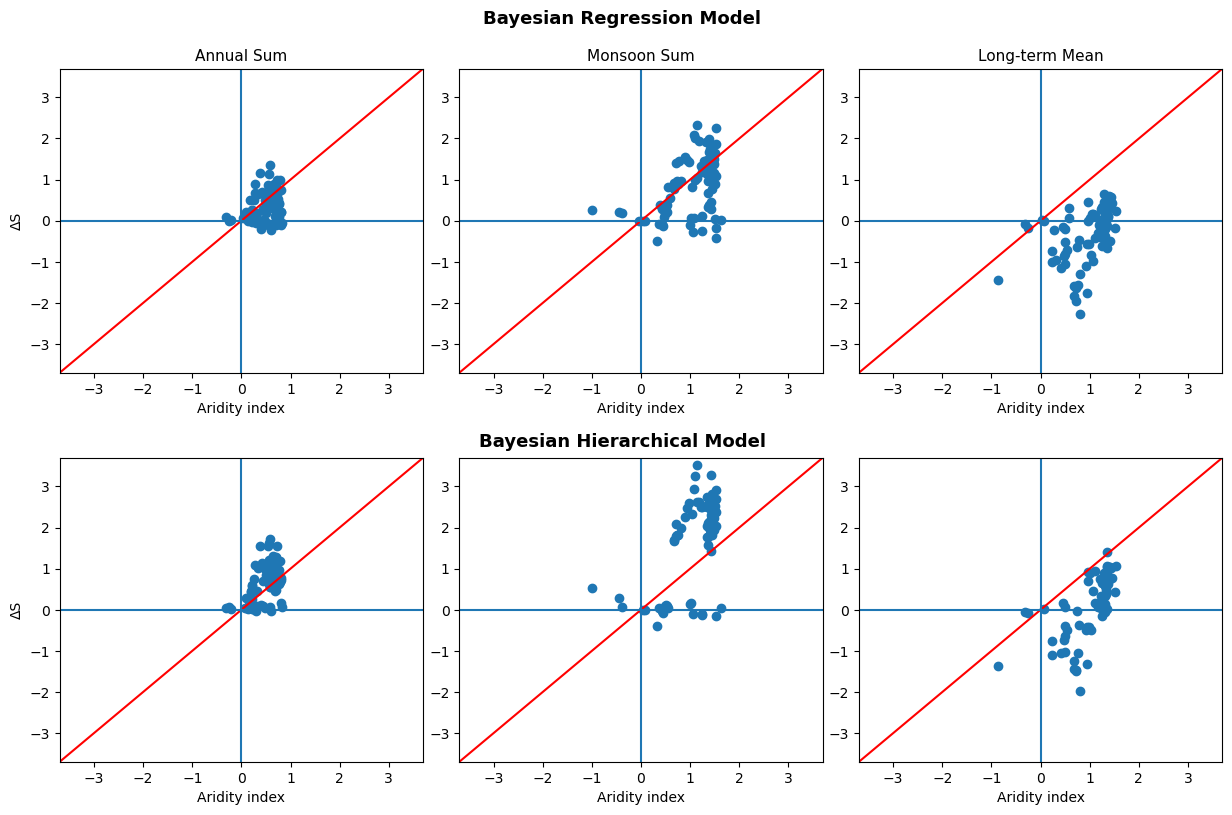

In [110]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- PATHS -----------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
delta_s_file = os.path.join(data_dir, "Delta_S_estimates.xlsx")
plot_dir = os.path.join(data_dir, "spatial plots")
# ----------------- LOAD DATA -----------------
df_BR = pd.read_excel(delta_s_file, sheet_name="BR")
df_BH = pd.read_excel(delta_s_file, sheet_name="BH")

# ----------------- TIMESCALE ORDER -----------------
timescales = ["Asum", "Msum", "ltm"]
titles = ["Annual Sum", "Monsoon Sum", "Long-term Mean"]

# ----------------- GLOBAL SYMMETRIC LIMITS -----------------
all_aridity = pd.concat([df_BR["Aridity_mean"], df_BH["Aridity_mean"]])
all_delta_s = pd.concat([df_BR["Delta_S_mean"], df_BH["Delta_S_mean"]])

lim = np.nanmax(np.abs(np.concatenate([all_aridity.values, all_delta_s.values])))
lim *= 1.05

# ----------------- FIGURE -----------------
fig, axes = plt.subplots(2, 3, figsize=(15, 9), gridspec_kw={"wspace": 0.1, "hspace": 0.28})

# ----------------- PLOTTING -----------------
for col, (ts, title) in enumerate(zip(timescales, titles)):

    # ---------- BR (Row 1) ----------
    ax = axes[0, col]
    d = df_BR[df_BR["Timescale"] == ts]

    ax.scatter(d["Aridity_mean"], d["Delta_S_mean"])
    ax.plot([-lim, lim], [-lim, lim], color="red")

    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Aridity index")
    ax.set_ylabel("ΔS" if col == 0 else "")
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.axhline(0)
    ax.axvline(0)


    # ---------- BH (Row 2) ----------
    ax = axes[1, col]
    d = df_BH[df_BH["Timescale"] == ts]

    ax.scatter(d["Aridity_mean"], d["Delta_S_mean"])
    ax.plot([-lim, lim], [-lim, lim], color="red")

    ax.set_ylabel("ΔS" if col == 0 else "")
    ax.set_xlabel("Aridity index")
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.axhline(0)
    ax.axvline(0)

# ----------------- ROW SUBTITLES -----------------
fig.text(0.5, 0.93, "Bayesian Regression Model",
         ha="center", fontsize=13, fontweight="bold")

fig.text(0.5, 0.46, "Bayesian Hierarchical Model",
         ha="center", fontsize=13, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(os.path.join(plot_dir, "5 scatter_aridity_delta_S.png"), dpi=400, bbox_inches="tight")
plt.show()
